# 5.1 중고나라 휴대폰 거래가격 예측하기

## 1. 탐색적 데이터 분석 : 중고나라 데이터 분석하기


```
create_date : 판매(혹은 구매) 게시글이 올라온 시점
price : 게시글 작성자가 제안한 휴대폰의 거래가격
text : 게시글의 제목과 본문을 합친 텍스트 데이터
phone_model : 휴대폰의 기종
factory_price : 휴대폰 공시가격
maker : 휴대폰 제조사
price_index : 판매 게시글이 올라온 시점에서의 휴대폰 물가 지수 데이터
```

In [1]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_phone.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB


In [3]:
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [4]:
df.isnull().sum()

create_date      0
price            0
text             0
phone_model      0
factory_price    0
maker            0
price_index      0
dtype: int64

-> 결측값 없이 구성됨을 알 수 있다.

### 개별 feature 탐색

#### date

In [5]:
# create_date로부터 'month' 정보 추출
df['month'] = df['create_date'].apply(lambda x : x[:7])

In [6]:
# 월별 거래 횟수
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

-> 2016년 10월, 2017년 3월에 집중적으로 수집된 데이터라는 것을 알 수 있다.

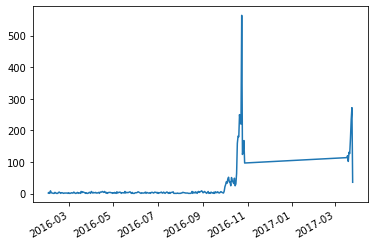

In [7]:
# 일별 거래 횟수 시각화 (일자별 시계열 그래프)
df_day = pd.to_datetime(df['create_date'].apply(lambda x : x[:10])).value_counts()
df_day.plot()
plt.show()

#### price

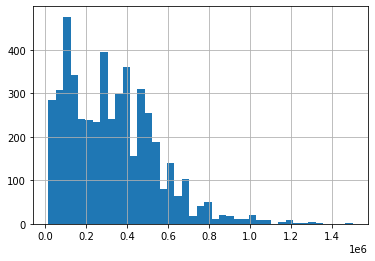

In [8]:
# 중고 휴대폰 가격 시각화
df['price'].hist(bins='auto')

-> 대부분의 중고 휴대폰이 60만원 이하의 가격대를 형성하고 있으며, 몇몇은 그 이상에도 거래되고 있는 것을 알 수 있다.

- 휴대폰의 동일 기종 내에서의 가격 분포를 보자.  
    -> 그룹별 평균값, 표준편차 구한 뒤, 모든 price의 z-core 계산해야 됨.  
    -> 이 값은 '동일 기종' 내에서의 상대적 가격을 나타내는 값!

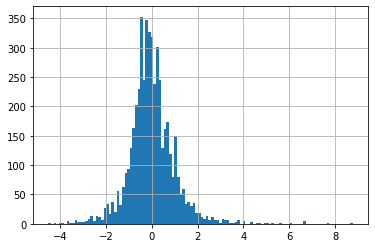

In [9]:
# 휴대폰 기종별 가격의 mean, std 계산
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x : np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x : np.std(x))

# 이를 바탕으로 모든 데이터의 z-score 계산
# 이는 해당 데이터의 가격이 기종별 평균에 비해 어느 정도로 높거나 낮은지를 알 수 있게하는 점수
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins='auto')

-> 동일 기종 내에서 price 분포는 정규분포에 가깝다는 것을 알 수 있다. 

#### factory_price : 휴대폰 공시가격(출고가)

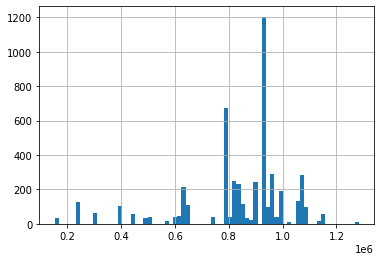

In [10]:
df['factory_price'].hist(bins='auto')

- factory_price와 price 간의 상관 관계 탐색

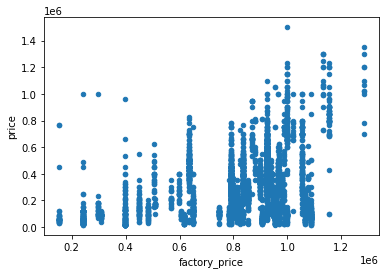

In [11]:
df.plot.scatter(x='factory_price', y='price')

-> 두 feature는 양의 상관 관계를 갖고 있다.  
-> factory_price는 중고 휴대폰 판매 가격에 꽤 중요한 영향을 미칠 것이라고 추정할 수 있다.

#### phone_model : 휴대폰의 기종

In [12]:
# 기종별 총 거래 데이터 개수
model_counts = df['phone_model'].value_counts()
model_counts.describe()

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x7f9b915e6828>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9b915f3278>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b915f3cf8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b915f3978>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9b915e6b38>,
  <matplotlib.lines.Line2D at 0x7f9b915e6eb8>]}

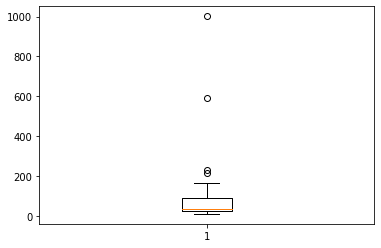

In [13]:
plt.boxplot(model_counts)

-> 상위 5개의 기종을 제외하면 대부분 10 ~ 90개 사이의 데이터를 가지고 있다.


#### maker : 휴대폰 제조사

In [14]:
maker_counts = df['maker'].value_counts()
maker_counts

apple      2450
samsung    1642
lg          677
pantech      57
sony         37
huawei       35
tg           28
sky          25
Name: maker, dtype: int64

{'boxes': [<matplotlib.lines.Line2D at 0x7f9b9154c630>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9b91558080>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b91558b00>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b91558780>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9b9154c940>,
  <matplotlib.lines.Line2D at 0x7f9b9154ccc0>]}

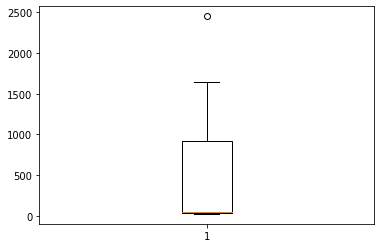

In [15]:
plt.boxplot(maker_counts)

-> 3개의 제조사가 대부분의 데이터를 대표하고 있는 것을 알 수 있다.

#### price_index : 판매 게시글이 올라온 시점에서의 휴대폰 물가 지수 데이터


In [16]:
df['price_index'].value_counts()

103.05    3061
95.96     1311
102.59     448
94.90      131
Name: price_index, dtype: int64

-> 핸드폰 물가의 변동률은 매 달마다 일어나지 않는다는 것을 알 수 있다.

### Random forest regressor를 이용한 가격 예측

<랜덤 포레스트 모델>  
- Decision Tree 분석 방법을 응용한 것
- Decision Tree를 여러 개 모아 하나의 숲을 구성하는 방법
- 하나의 모델이 정답을 푸는 것이 아닌, 여러 개의 모델이 정답을 함께 푸는 것이기 때문에 더 정확한 학습이 가능
- 또한, 모델이 생성되는 과정에서의 feature 중요도를 계산하기 때문에 EDA에 자주 사용됨.
- 회귀, 분류 두 가지에 모두 적용 가능

In [17]:
df.head(2)

,create_date,price,text,phone_model,factory_price,maker,price_index,month
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,2017-03
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2016-10


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])

X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
# 랜덤 포레스트 모델 학습
forest = RandomForestRegressor(n_estimators=1000,
                              criterion='mse')
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델 평가
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 10618709947.784, test: 13858442343.685
R^2 train: 0.781, test: 0.683


-> train score와 test score의 차이가 심한 것을 미루어 볼 때, 이 예측 모델은 overfitting이 일어났다고 볼 수 있다.

#### 피처 중요도

<BarContainer object of 84 artists>

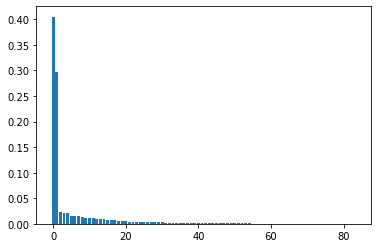

In [20]:
# 학습한 모델의 피처 중요도를 그래프로 살펴보자.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # 중요도 높은 순으로 정렬
plt.bar(range(X.shape[1]), importances[indices])

In [21]:
# 학습한 모델의 피처 중요도 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

[('factory_price', 0.40499025880948913),
 ('maker_apple', 0.2972937380927599),
 ('phone_model_galaxy s3 3g 8gb', 0.022615975864557016),
 ('phone_model_iphone se 64gb', 0.021670714265040837),
 ('price_index', 0.020600837760552444),
 ('phone_model_galaxy s4 32gb', 0.016215281176546924),
 ('month_2017-03', 0.014893827549648454),
 ('maker_samsung', 0.014351377234268586),
 ('phone_model_galaxy s6 32gb', 0.012652354975677429),
 ('month_2016-05', 0.011063308404311125)]

#### 시간이 모델에 미치는 영향 확인

In [22]:
# month 피처 중요도 확인
for sorted_feature in sorted(feature, key=lambda tup : tup[1], reverse=True):
    if 'month' in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.014893827549648454)
('month_2016-05', 0.011063308404311125)
('month_2016-09', 0.008696283810970583)
('month_2016-04', 0.007574771313265028)
('month_2016-10', 0.006305774604509536)
('month_2016-06', 0.004365323989014845)
('month_2016-08', 0.003646592738677108)
('month_2016-07', 0.0027569444197759474)
('month_2016-03', 0.0023088397254208562)
('month_2016-02', 0.001016813111580157)


-> 최근에 가까운 'month'일수록 피처 중요도가 높은 것을 알 수 있다.

#### 예측 결과 scatter plot


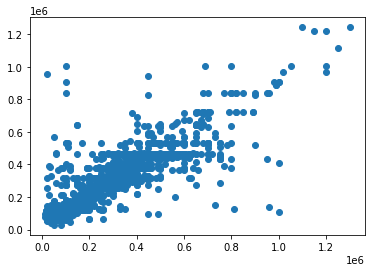

In [23]:
plt.scatter(y_test.values, y_test_pred)

## 2. feature engineering : 예측 모델 개선

- date  
: 월 단위로 살펴본 결과, 2016년 10월과 2017년 3월의 데이터가 가장 많다. 최근에 가까운 month일수록 예측 모델에 중요한 feature이다.  
        => 게시글의 등록 month 파생 가능  


- price  
: 전체 휴대폰의 거래가와 달리, 기종별 가격의 분포는 정규 분포의 형태를 띠고 있다.  
        => 동일 기종 내 상대 가격 (z-score)  
 
 
- factory_price  
: price와의 양의 상관 관계가 관찰된다. 또한, 예측 모델의 피처 중요도 분석 결과, 가장 중요한 feature로 나타났다.  


- phone_model  
: 소수의 인기 기종이 많은 데이터를 가지고 있다.  
        => 휴대폰 세부 기종, 용량으로 분리한 2개의 feature  
    
    
- maker  
: Apple 브랜드가 가장 많으며, 가격 예측에서도 Apple 브랜드 여부는 가장 중요한 feature 중 하나이다.  


- price_index  
: 월별 변동이 크지 않으며, 총 4개의 값만 갖고 있다. 가격 예측에서 그다지 중요한 feature는 아니다. 

### 기존 feature 가공

In [24]:
# data 다시 불러오기
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_phone.csv')

#### create_date로 시간점수 생성

1) create_data를 unixtime으로 변환한다.  
unixtime은 시간을 정수로 표현한 것이며, 값이 클수록 '최근'에 가까워진다.  

2) min-max scaling을 적용하여 unixtime을 상대적인 점수로 계산한다.  

3) 점수가 1에 가까울수록 최근에 작성한 게시물을 의미하며, 0에 가까울수록 오래된 게시물을 의미한다.

In [25]:
from datetime import datetime
import time

# create_date feature를 수치적으로 계산하기 위해, unixtime으로 변환하는 함수를 정의
def date_to_unixtime(date_str):
    timestamp = time. mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

# create_date feature를 '현재와 얼마나 가까운 데이터인지' 판단하기 위한 점수를 생성.
# 먼저 unixtime으로 데이터를 변환
df['create_unixtime'] = df['create_date'].apply(lambda x : date_to_unixtime(x[:10]))
df['create_unixtime'][:10]

0    1.489882e+09
1    1.477440e+09
2    1.477354e+09
3    1.490227e+09
4    1.460333e+09
5    1.490141e+09
6    1.490227e+09
7    1.475798e+09
8    1.490400e+09
9    1.458691e+09
Name: create_unixtime, dtype: float64

In [26]:
# 변환된 unixtime에 min-max scaling 적용
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
(df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489882e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477440e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477354e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490227e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460333e+09,0.165468


#### phone_model 분리

In [27]:
df['phone_model'].head()

0          iphone 6 64gb
1    galaxy s6 edge 32gb
2         galaxy s6 32gb
3             lg g5 32gb
4              lg u 32gb
Name: phone_model, dtype: object

-> '제품명 + 용량'으로 구성되어 있기 때문에 이를 나누어주자.

In [28]:
# 저장 용량(phone_model_storage)
df['phone_model_storage'] = df['phone_model'].apply(lambda x : x.split(" ")[-1])

# 기종 세부명(phone_model_detail)
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))

df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


{'boxes': [<matplotlib.lines.Line2D at 0x7f9b8bec2c88>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9b8bed06a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b8beda160>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b8bed0da0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9b8bec2f60>,
  <matplotlib.lines.Line2D at 0x7f9b8bedabe0>]}

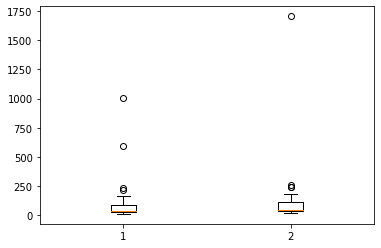

In [29]:
# phone_model : 기종별 거래 데이터 개수
model_counts = df['phone_model'].value_counts()

# phone_model_detail : 기종별 거래 데이터 개수
model_detail_counts = df['phone_model_detail'].value_counts()

data = [model_counts, model_detail_counts]

# 두 feature 간의 기종별 거래 데이터 개수를 비교
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111) # == fig.add_subplot(1,1,1)
ax.boxplot(data)

<feature를 분리함으로써 얻을 수 있는 효과>  
-> 쏠림 현상이 심해진 하나의 기종을 제외하면 전체적인 분포가 안정적으로 변한 것을 알 수 있다.  
-> 게다가 분석에 덤으로 사용할 수 있는 'phone_model_storage'라는 새로운 feature까지 생김

#### phone_model 관련 딕셔너리 생성

In [30]:
# 기종명 + 용량으로 출고가를 찾기 위한 딕셔너리를 생성
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['phone_model_detail'], row['phone_model_storage'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], '...')

{('iphone 6', '64gb'): 924000, ('galaxy  ...


### 감성분석으로 물품의 상태 분류

- 텍스트 정보에는 물품의 상태가 나타나 있을 것  
    -> 가격 예측에 영향 미칠 것이다.  
    -> 물품의 상태를 분류할 수 있는 __감성 분류__가 필요하다.  
    

- 감성 분류의 정답 __'상태가 좋다' / '상태가 나쁘다'__의 판단 방법?  
    -> __'기종별 가격의 분포는 정규분포다'__라는 정보 활용하자!  
    
> 1) price를 같은 기종 내에서의 z-score로 변환한다.  
> 2) z-score 기준, 상위 5%에 속하는 가격의 게시글은 '상태가 좋음', 하위 5%는 '상태가 나쁨', 그리고 그 외는 '보통'으로 판단.  
> 3) 정의한 세 가지 상태를 감성 분류의 정답 데이터로 사용

In [31]:
# 거래 가격(price)의 z-score 계산
# 이는 해당 데이터의 가격이 기종의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수이다. 
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

-1.3966616903783426
1.666982156397844


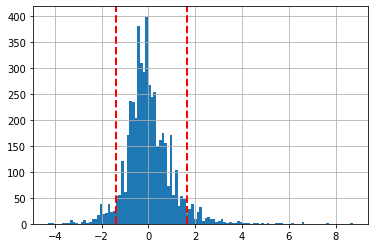

In [32]:
# 거래 가격의 z-score(price_by_group)의 분포 시각화
ax = df['price_by_group'].hist(bins='auto')

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 
# lower_bound, upper_bound 라고 지정
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

# lower_bound, upper_bound 출력
print(lower_bound)
print(upper_bound)

In [33]:
def get_price_level(price, lower, upper):
    if price <= lower:
        return '0'
    elif price >= upper:
        return '2'
    else:
        return '1'
    
df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], row['price_upper']), axis=1)

df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


#### 텍스트 전처리

In [35]:
import pickle
import re

# 중고나라 불용어 사전 불러오기
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_phone_stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)
    
# 불용어 사전에 등록된 단어 출력
stopwords

['거래',
 '입니',
 '판매',
 '아이폰',
 '갤럭시',
 '골드',
 '팝',
 '만원',
 '폰',
 '시',
 '주세',
 '노트',
 '문자',
 '화이트',
 '연락',
 '블랙',
 '구매',
 '및',
 '기재',
 '년',
 '품',
 '월',
 '용',
 '로즈',
 '상세',
 '항목',
 '완료',
 '지역',
 '개',
 '실버',
 '신청하기',
 '색상',
 '타',
 '기기',
 '서울',
 '후',
 '문의',
 '원',
 '설명',
 '판',
 '전화',
 '엣지',
 '모두',
 '경우',
 '보시',
 '위',
 '정확히',
 '정도',
 '될',
 '등',
 '휴대폰',
 '되',
 '일',
 '플러스',
 'g',
 'lg',
 'skt',
 'gb',
 'kt',
 'sk',
 'se',
 'lgu',
 'u',
 'lte',
 'fl',
 'ltea',
 'nl',
 'k',
 'z',
 'v',
 'lgt',
 'gs',
 'gl',
 'ss',
 'cat',
 'nk',
 'b',
 'com',
 'gpro',
 'ea',
 'ns',
 'ios',
 'gt',
 'or',
 'usb',
 'amp',
 'umi',
 'lgfl',
 'es',
 'howufeel',
 'gk',
 'ek',
 'xperia',
 'y',
 'wpi',
 'mtk',
 'd',
 'www',
 'sss',
 'fs',
 'el',
 'lglp',
 'white',
 'http',
 'o',
 'l',
 'zv',
 'e',
 'al',
 'gn',
 'ps',
 'naver',
 'rome',
 'gx',
 'lglb',
 'ssanmai',
 'f',
 '계',
 '명',
 '들',
 '적',
 '자',
 '상',
 '화',
 '대',
 '중',
 '장',
 '간',
 '네',
 '분',
 '권',
 '이',
 '백',
 '째',
 '형',
 '분들',
 '번째',
 '씩',
 '쯤',
 '식',
 '조',
 '성',
 '

#### 형태소 단위로 추출

- 텍스트에서 특수문자를 제거한다. 단, '+'와 ',' 문자는 제거 x  
- 텍스트에서 숫자를 제거한다.

In [38]:
! pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 6.8MB/s 
     |████████████████████████████████| 460kB 27.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [40]:
from konlpy.tag import Okt

# 특수문자, 숫자 제거하는 함수
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

In [41]:
# 위 함수들을 적용한 형태소 추출 test
df['text'] = df['text'].apply(lambda x : text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


#### 빈출 형태소 2500개 선정

- 단어 개수 제한하는 이유?  
: 텍스트 데이터의 feature를 제한하기 위함  
: 만약 이를 제한하지 않으면 텍스트 데이터의 feature는 몇 만개, 혹은 몇 백만 개로 늘어날 수 있기 때문

In [42]:
from collections import Counter

# get_pos 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), []) # 2차원 리스트 flatten 하게

# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개 추출
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

#### TF-IDF 벡터 생성

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 빈출 형태소를 제외한 모든 형태소 제거하는 함수
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 클래스 불균형 맞춰주기 위해 부정 : 중립 : 긍정 = 1 : 3 : 1 로 추출
# 일반적으로는 1:1:1로 데이터를 추출하지만, 예제에서는 부정, 긍정 데이터의 양이 많지 않기 때문에
# 중립 데이터의 비중 늘림

# 1:3:1 비율로 random sampling
negative_random = df[df['price_level']=='0'].sample(321, random_state=30)
neutral_random = df[df['price_level']=='1'].sample(321*3, random_state=30)
positive_random = df[df['price_level']=='2'].sample(321, random_state=30)

# sampling 완료된 데이터셋 정의
df_sample = negative_random.append(neutral_random).append(positive_random)

In [44]:
# TF-IDF를 수행하여 feature 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x : get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [45]:
# 감성 분류를 위한 학습 데이터셋 정의
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
print(x_train.shape)
print(x_test.shape)

(1284, 2476)
(321, 2476)


-> 형태소를 표현하는 features 2476개 생성

#### 상품 상태 분류하기

- TF-IDF feature 변환이 완료된 데이터셋으로 분류 모델 학습
- 분류 모델은 SVM 사용

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 비선형 SVM 분류 모델 학습 & 평가
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))   

Accuracy: 0.77


-> 정확도 약 0.8 정도

In [47]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
confmat

array([[ 30,  28,   4],
       [ 10, 181,  10],
       [  2,  21,  35]])

-> 꽤나 정확하게 분류 모델이 학습되었음을 알 수 있다.

## 3. 예측 : 중고폰 거래가 예측

- create_time_score  
: create_date을 unixtime으로 바꾸어 얼마나 오래된 게시물인지를 0 ~ 1 사이의 값으로 계산하여 표현. 1에 가까울수록 최근에 작성한 게시물을 의미  


- phone_model_storage, phone_model_detail  
: phone_model을 둘로 나눈 것  


- product_status  
: 동일 기종 내 상대 가격을 기준으로 텍스트 데이터의 감성(상품 상태)을 분류한 것. 상품의 상태는 3개의 범주로 표현

### Random forest regressor 재학습

In [48]:
# text feature로부터 상품상태(product_status) feature 생성
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

#### 새로운 feature로 예측 모델 다시 학습

In [49]:
# Random forest 모델 학습 위한 데이터 준비
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage',
         'phone_model_detail', 'product_status']]
df = pd.get_dummies(df, columns=['maker', 'phone_model_storage', 'phone_model_detail', 'product_status'])

# train/test 데이터 분리
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Random forest 모델 학습 & 평가
forest = RandomForestRegressor(n_estimators=1000, criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 4773839637.869, test: 11065510049.717
R^2 train: 0.902, test: 0.747


-> train R^2, test R^2 는 매우 상승  
-> 그러나 여전히 overfitting

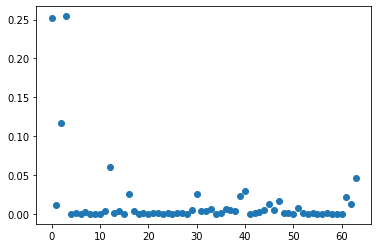

In [50]:
# feature 중요도 시각화
importances = forest.feature_importances_
plt.plot(importances, "o")

In [51]:
# feature 중요도 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

[('maker_apple', 0.2542874282427835),
 ('factory_price', 0.2524190332580538),
 ('create_time_score', 0.11690084025697292),
 ('phone_model_storage_16gb', 0.060752385539012216),
 ('product_status_2', 0.046808240740998396),
 ('phone_model_detail_galaxy s7 edge', 0.029179790703090364),
 ('phone_model_storage_64gb', 0.025808200505920833),
 ('phone_model_detail_galaxy note5', 0.025263349902473146),
 ('phone_model_detail_galaxy s7', 0.023012419008548935),
 ('product_status_0', 0.021801939644994224)]

-> 영향력이 높은 feature 중 __create_time_score, product_status__가 있다는 것을 확인할 수 있다.  
-> 새로운 feature가 중요한 역할을 수행하고 있다!

#### feature-index 관련 딕셔너리 생성

In [60]:
# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'price_index': 1, ' ...


#### 예측 결과 scatter plot

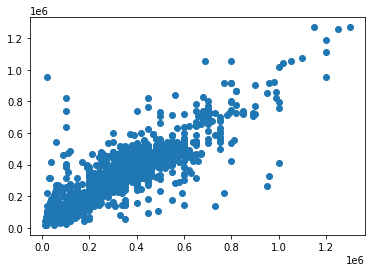

In [52]:
plt.scatter(y_test.values, y_test_pred)

-> 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계 확인  
-> 몇몇 이상치를 제외하면 예측이 잘 수행된 것을 확인할 수 있다.

### 최적의 모델 파라미터 찾기


- Random forest의 경우 __n_estimators와 max_depth__를 잘 설정하는 것이 중요함.
- 이러한 최적의 파라미터는 반복적인 시도와 검증으로 찾아내야 함.
- 반복적인 실행으로 최적의 파라미터를 찾아내는 방법 중 하나가 __Greedy Randomized Search__라는 방법이다.

In [53]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

# RandomizedSearchCV 모델 학습
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 30.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

#### 최적 파라미터 출력

In [54]:
# 앞서 선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합 출력
optimal_forest.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 2000}

#### 최적 모델 학습 결과

In [55]:
# 최적의 파라미터를 적용한 모델로 중고폰의 가격을 예측 & 평가
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 8808353780.813, test: 7645656807.452
R^2 train: 0.818, test: 0.825


-> train socre는 다소 감소했지만, test score와의 차이가 현저하게 좁혀진 것을 볼 수 있다.  
-> 따라서 모델이 가지고 있던 overfitting 문제가 해결되었다고 할 수 있다.

<BarContainer object of 64 artists>

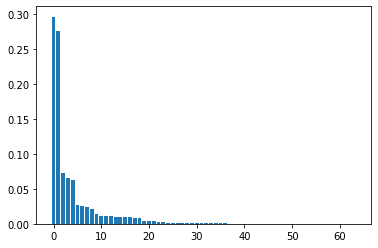

In [56]:
# 가격 예측 모델의 feature 중요도 시각화
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

In [57]:
# 가격 예측 모델의 feature 중요도 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

[('factory_price', 0.29659023022788283),
 ('maker_apple', 0.2756146339717085),
 ('phone_model_storage_16gb', 0.07214534782417117),
 ('create_time_score', 0.06571103416216734),
 ('product_status_2', 0.06262322786791343),
 ('phone_model_detail_galaxy s7 edge', 0.027077100968397844),
 ('phone_model_detail_iphone 6', 0.025017646403248585),
 ('product_status_0', 0.024447614450927697),
 ('phone_model_detail_galaxy s4', 0.02053025298822131),
 ('product_status_1', 0.013814045602771493)]

#### 예측 결과 scatter plot

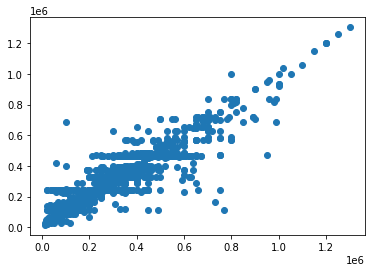

In [58]:
plt.scatter(y_test.values, y_test_pred)

-> 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계 확인  
-> 파라미터를 최적화 하기 이전보다 성능이 많이 향상된 것을 확인할 수 있다.

## 4. 프로토타입 : 얼마고(Almhago)?

- 지금까지 완성한 중고 휴대폰 가격 예측 모델을 프로그램의 형태로 만들어보자.
- 이를 통해 데이터 분석을 서비스에 활용하는 방법을 알아본다.


- 프로그램 <얼마고(Almhago)?>는 미리 학습한 모델과 feature로 중고 휴대폰의 가격을 예측한다. 
- 하지만 프로그램을 실행할 때마다 모델을 학습할 수는 없다. 
- 따라서 다음에 다룰 코드를 통해 모델과 feature 정보를 file 형태로 미리 저장해야 한다. 
- 저장하는 file의 리스트와 정보는 다음과 같다. 
> - model_to_factory_price_dict  
: 모델명, 용량으로 factory_price를 찾을 수 있는 파이썬 딕셔너리  
> - col_to_index_dict  
: dataframe의 feature를 번호로 표현한 파이썬 딕셔너리  
> - common_words  
: 가장 많이 등장하는 형태소 3000개의 정보  
> - index_vectorizer, tfidf_vectorizer  
: 텍스트 정보를 TF-IDF feature로 변환해주는 vectorizer  
> - svm  
: 텍스트 정보를 바탕으로 물품의 상태를 판별해주는 분류 모델 (svm 분류 모델)  
> - optimal_forest  
: 최적의 파라미터로 학습한 가격 예측 모델

### 재사용을 위한 file 저장

- pickle.load(파일) 을 통해서 파일 내용을 읽어오려면, pickle.dump를 사용해서 데이터를 입력한 파일이어야함.
- 바이너리 파일을 읽기 위해서는 파일모드를 rb 로, 쓰기 위해서는 wb 로 지정

In [61]:
from sklearn.externals import joblib

with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/common_words.pickle', 'wb') as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, '/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/rf_regressor.pickle', compress = 1)

['/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/rf_regressor.pickle']

### 가격 예측 프로그램 만들기

#### 예측에 필요한 파일 로드


In [62]:
import pickle

with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/common_words.pickle', 'rb') as f:
    common_words = pickle.load(f)

with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
    svm_classifier = pickle.load(f)

rf_regressor = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/data/used_mobile_pickles/rf_regressor.pickle')

### 프로그램(클래스) 만들기

- 지금까지의 모든 분석의 과정에 사용된 함수, 전처리 방법 등을 하나의 클래스로 만들기
- 이 클래스는 앞서 저장한 파일들을 활용하여 새로운 분석이나 학습의 과정 없이 이전에 분석했던 결과들을 실행할 수 있다.

In [64]:
import numpy as np

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, 
                 common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                 prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()
        self._tfidf_vectorizer = tfidf_vectorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
        
    def _get_common_pos(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = ''.join(c for c in text if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
        
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_ftr_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
        X = self._tfidf_vectorizer.transform(X)
        return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ''
        if prd_status == '0':
            status = '불량한'
        elif prd_status == '1':
            status = '양호한'
        else:
            status = '좋은'
        print('선택하신', model, '모델은', status, '상태입니다. Almhago 예상 가격은', str(int(price[0])), '원 입니다.')

    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['phone_model_detail'],
                                                                                input_dict['phone_model_storage'])
        feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict['phone_model_detail']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict['text'])])]] = 1

        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['phone_model_detail'],
                            predicted_price,
                            self._get_prd_status(input_dict['text']))

#### 프로그램 테스트

In [65]:
# 데이터의 가장 최근 시점인 2017년 4월을 기준으로 하기 위한 
# 두 개(price_index, create_time_score)의 feature를 정의
recent_price_index = 95.96
recent_create_time_score = 1.0

# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글을 입력
program_test_dict = {'maker' : 'apple',
                     'phone_model_detail' : 'iphone 6',
                     'phone_model_storage' : '16gb',
                     'text' : '아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요',
                     'price_index' : recent_price_index,
                     'create_time_score' : recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트를 생성
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)

# 입력한 데이터로 판매 가격 예측
almhago.predict(program_test_dict)

선택하신 iphone 6 모델은 불량한 상태입니다. Almhago 예상 가격은 152307 원 입니다.
